Demo notebook for Lecture 16. Kernel ridge regression on housing market dataset. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
datapath = '/content/drive/MyDrive/Courses/AMATH482582-WIN2022/Notebooks/HousingData/Realestateval.xlsx'

data = pd.read_excel(datapath)

In [3]:
print(data)

# convert the data to numpy array
d = np.array(data)

# separate the data into features X and output Y

X = d[:, 1:7]
Y = d[:,7]

print('X:', X)
print('Y:', Y)

      No  X1 transaction date  ...  X6 longitude  Y house price of unit area
0      1          2012.916667  ...     121.54024                        37.9
1      2          2012.916667  ...     121.53951                        42.2
2      3          2013.583333  ...     121.54391                        47.3
3      4          2013.500000  ...     121.54391                        54.8
4      5          2012.833333  ...     121.54245                        43.1
..   ...                  ...  ...           ...                         ...
409  410          2013.000000  ...     121.50381                        15.4
410  411          2012.666667  ...     121.54310                        50.0
411  412          2013.250000  ...     121.53986                        40.6
412  413          2013.000000  ...     121.54067                        52.5
413  414          2013.500000  ...     121.54310                        63.9

[414 rows x 8 columns]
X: [[2012.9166667   32.          84.87882     10.   

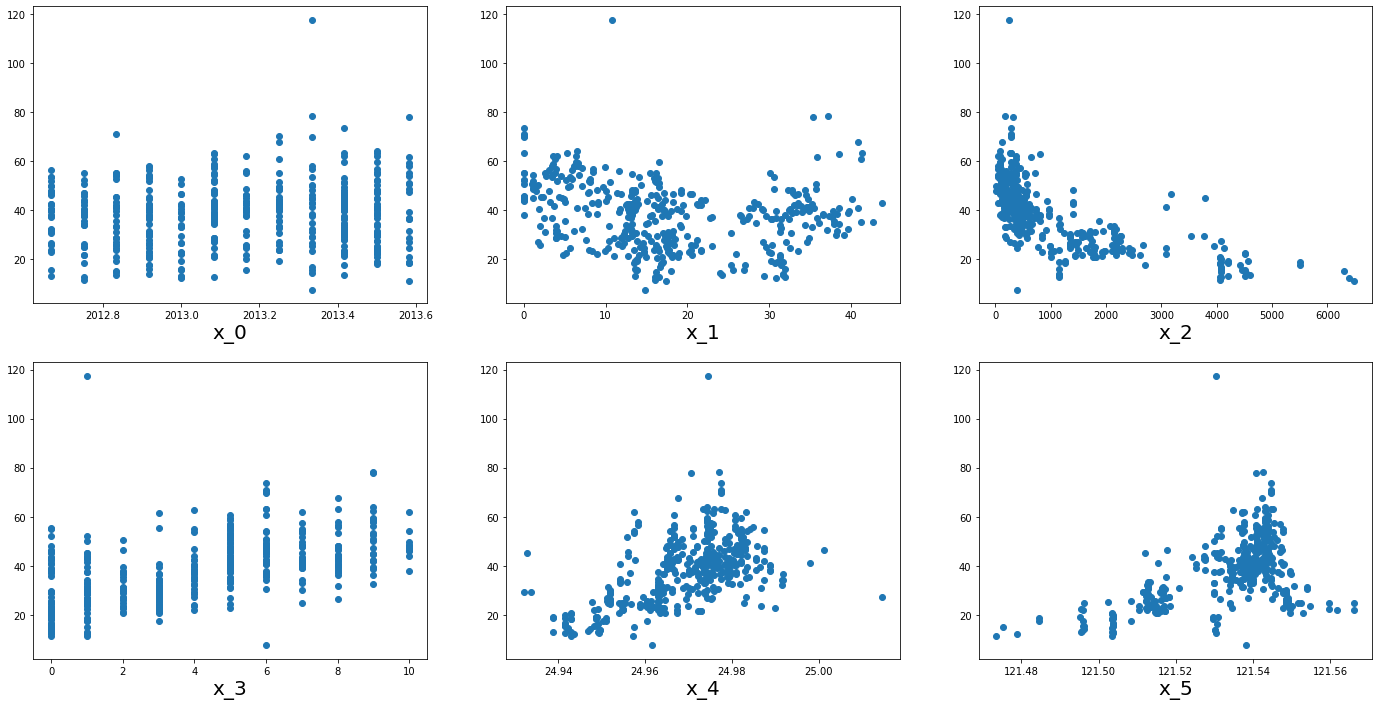

In [4]:
# generate some plots to visualize the data set 

fig, ax = plt.subplots(2,3, figsize=(24,12))

for j in range(2):
  for i in range(3):

    ax[j][i].scatter( X[:, i+ j*3], Y )
    ax[j][i].set_xlabel('x_'+str(i + j*3), fontsize=20)

Clearly there are some trends in the data. For example $x_3$ (numer of convenience stores nearby) seems to have a direct effect on the price. We now use Scikitlearn's kernel regression algorithm to fit a model to this data set. 

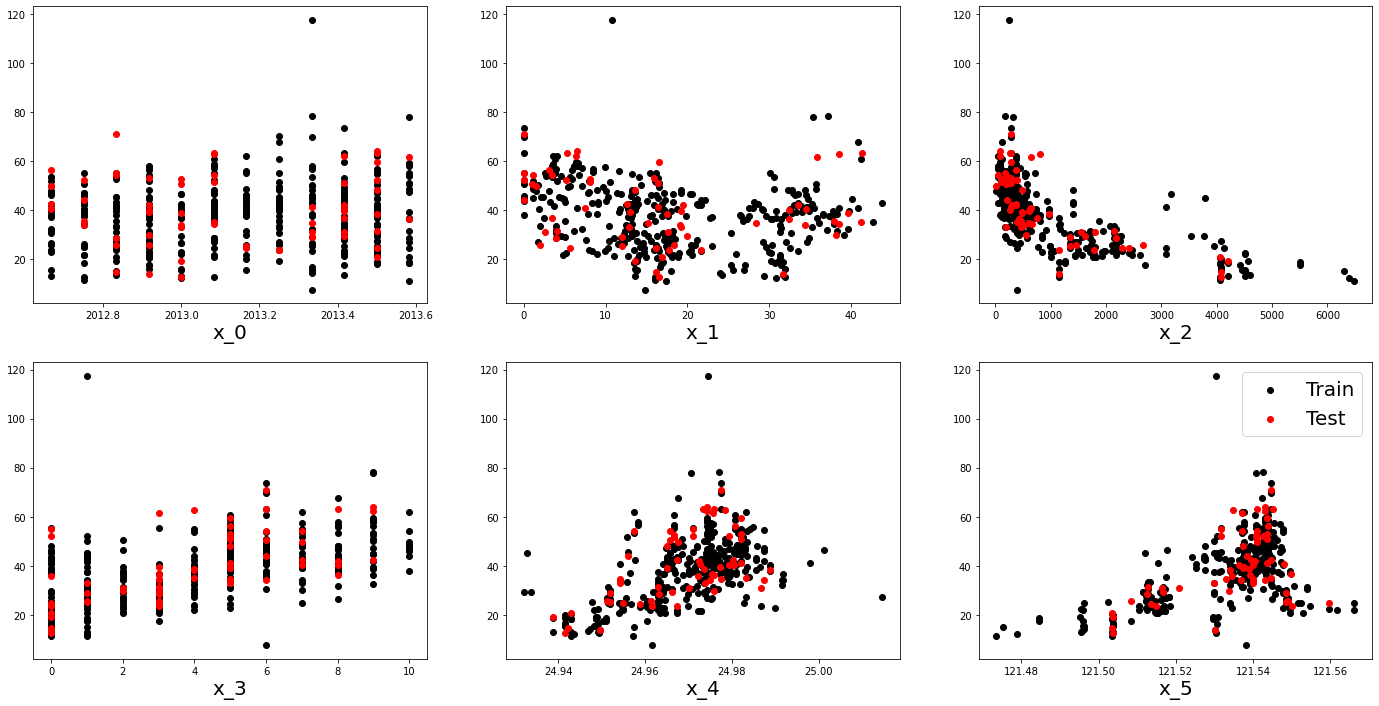

In [5]:
# First we use sklearn to split our data set into training and test sets 

import sklearn as skl
import sklearn.model_selection

# test_size is a number between 0.0 and 1.0, the ratio of test set to entire data set
X_train, X_test, Y_train, Y_test = skl.model_selection.train_test_split(X, Y, test_size=0.15, random_state=10 )

# plot the training and test sets 

fig, ax = plt.subplots(2,3, figsize=(24,12))

for j in range(2):
  for i in range(3):

    ax[j][i].scatter( X_train[:, i+ j*3], Y_train, color='k', label='Train' )
    ax[j][i].scatter( X_test[:, i+ j*3], Y_test, color='r', label='Test')
    ax[j][i].set_xlabel('x_'+str(i + j*3), fontsize=20)

plt.legend(fontsize=20)

(351, 6)
(351,)


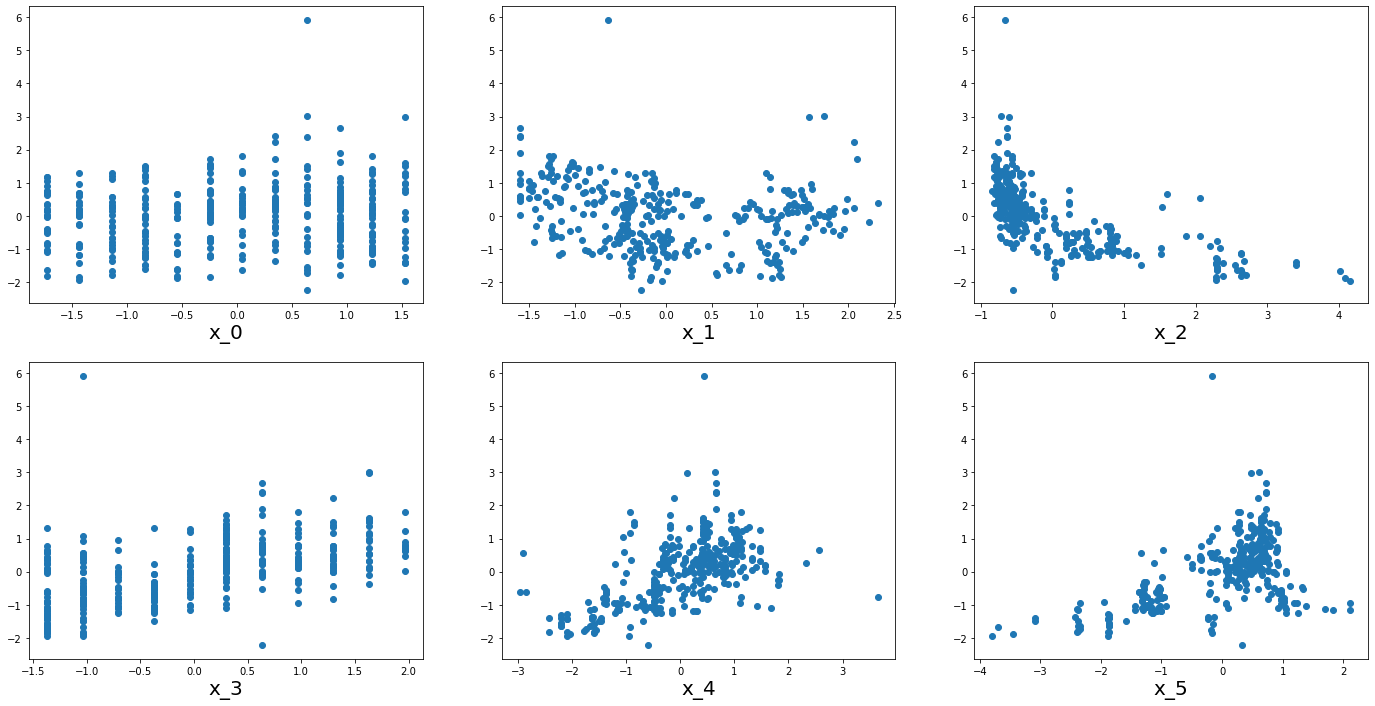

In [9]:
import numpy.matlib

# Next we normalize and center the training set

X_train_N = X_train.shape[0]

X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

X_train_normal = (X_train - np.matlib.repmat(X_train_mean, X_train_N, 1))/np.matlib.repmat(X_train_std, X_train_N, 1)

Y_train_N = Y_train.shape[0]

Y_train_mean = np.mean(Y_train, axis=0)
Y_train_std = np.std(Y_train, axis=0)

Y_train_normal = (Y_train - Y_train_mean)/Y_train_std

print(X_train_normal.shape)
print(Y_train_normal.shape)

fig, ax = plt.subplots(2,3, figsize=(24,12))

for j in range(2):
  for i in range(3):

    ax[j][i].scatter( X_train_normal[:, i+ j*3], Y_train_normal )
    ax[j][i].set_xlabel('x_'+str(i + j*3), fontsize=20)

# while we're here we also normalize and center the test set. 
# NOTE: the shift and scaling here are those computed on the training set 
X_test_N = X_test.shape[0]

X_test_normal = (X_test - np.matlib.repmat(X_train_mean, X_test_N, 1))/np.matlib.repmat(X_train_std, X_test_N, 1)
Y_test_normal = (Y_test - Y_train_mean)/Y_train_std

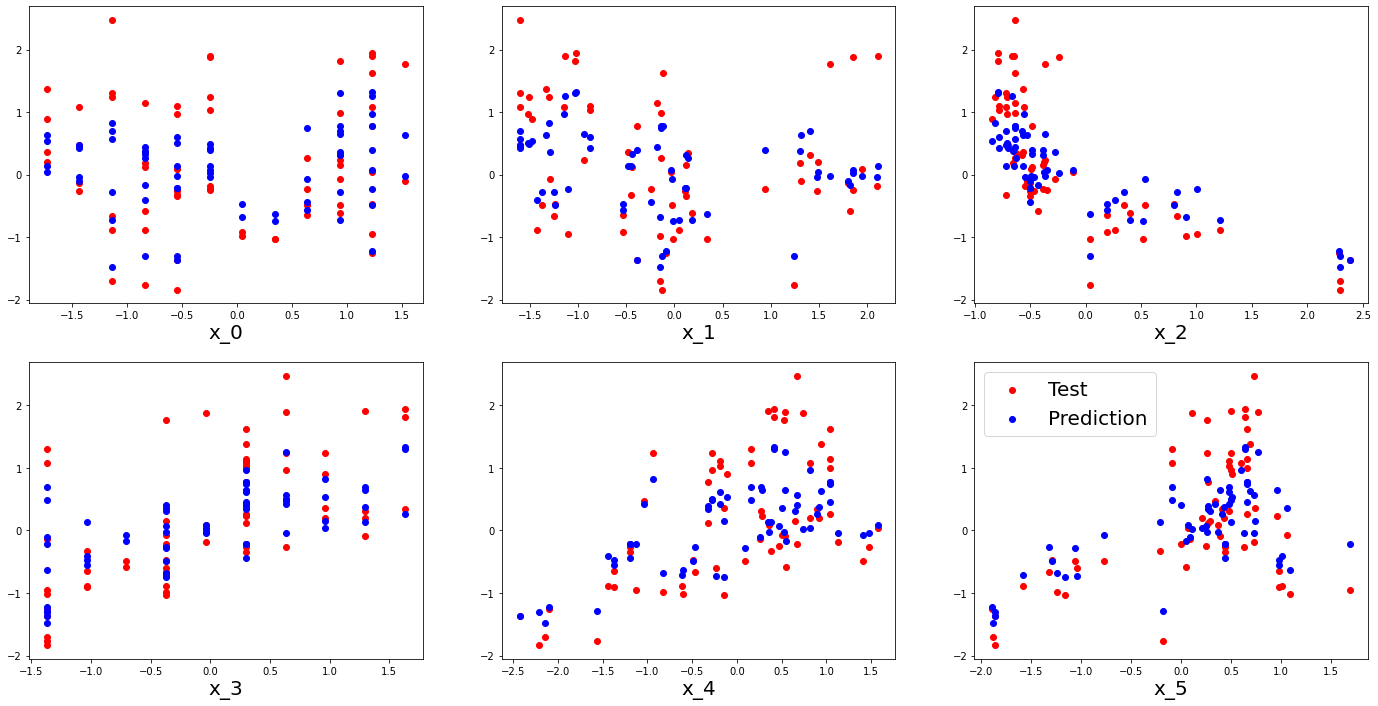

In [78]:
# now we can use sklearn's kernel ridgeregression function to fit our model. We will first do this with a 
# fixed kernel length scale then use CV to choose the length scale as well. Test error will be reported on the test set

import sklearn.kernel_ridge

# see https://scikit-learn.org/stable/modules/metrics.html#metrics for possible choices of kernels
sigma = 0.5



KRR = skl.kernel_ridge.KernelRidge(kernel='rbf', alpha = 0.9, gamma=1/(2*sigma**2))

KRR.fit(X_train_normal, Y_train_normal)

# use our fitted model to predict the Y values on the test set 
Y_pred_normal = KRR.predict(X_test_normal)

# plot the predicted values of Y against the test set

fig, ax = plt.subplots(2,3, figsize=(24,12))

for j in range(2):
  for i in range(3):

    ax[j][i].scatter( X_test_normal[:, i+ j*3], Y_test_normal, color='r', label='Test' )
    ax[j][i].scatter( X_test_normal[:, i+ j*3], Y_pred_normal, color='b', label='Prediction' )
    ax[j][i].set_xlabel('x_'+str(i + j*3), fontsize=20)

plt.legend(fontsize=20)



You can play around with the above code to see the profound impact of the $\gamma$ and $\alpha$ parameters on the performance of the model. To address this we will now employ CV. Note that we have two parameters to optimize over so this is not going to be cheap. But the problem is small enough that we can do it.

In [73]:
# range of values of sigma to try 


K_sgm = 10
K_lmbd = 10

sgm = np.linspace(-5, 0, K_sgm)
lmbd = np.linspace(-5, 0, K_lmbd)

scores = np.zeros((K_sgm, K_lmbd))
scores_std = np.zeros((K_sgm, K_lmbd))

KRR_CV = skl.kernel_ridge.KernelRidge(kernel='rbf')

for i in range(K_sgm):

  KRR_CV.gamma = 1/(2*(2**sgm[i])**2)

  for j in range(K_lmbd): 

    KRR_CV.alpha = (2**lmbd[j])
    this_score = skl.model_selection.cross_val_score(KRR_CV, X_train_normal, Y_train_normal)

    scores[i,j] = np.abs(np.mean(this_score))
    scores_std[i,j] = np.abs(np.std(this_score))


print(scores)

[[0.07536454 0.07538201 0.0753445  0.07516939 0.07469763 0.0736543
  0.071625   0.06809524 0.06260305 0.0549892 ]
 [0.07660564 0.07664237 0.07663043 0.07648759 0.0760534  0.07504816
  0.07304783 0.06952318 0.06399569 0.0562946 ]
 [0.08373957 0.08370871 0.08359892 0.08331599 0.08268436 0.08140682
  0.0790418  0.07504768 0.06894589 0.06058481]
 [0.10130992 0.10114337 0.10082872 0.10024439 0.09917963 0.09729506
  0.09410483 0.08903196 0.0815886  0.07165744]
 [0.16271177 0.1619552  0.16083686 0.15913982 0.15652932 0.15251854
  0.14646968 0.13768783 0.12565616 0.1103697 ]
 [0.26107477 0.26010801 0.25871487 0.25659145 0.25325193 0.24797395
  0.23978722 0.22758636 0.21044768 0.18811911]
 [0.34908633 0.35103258 0.35331378 0.35569947 0.35762577 0.35805011
  0.35536438 0.34750034 0.33235354 0.30851469]
 [0.39854576 0.41017913 0.42375536 0.43863417 0.45357761 0.4667803
  0.47603011 0.47892585 0.47312035 0.45665681]
 [0.38475339 0.41754505 0.45066582 0.48215245 0.51022562 0.53351642
  0.55102665 0

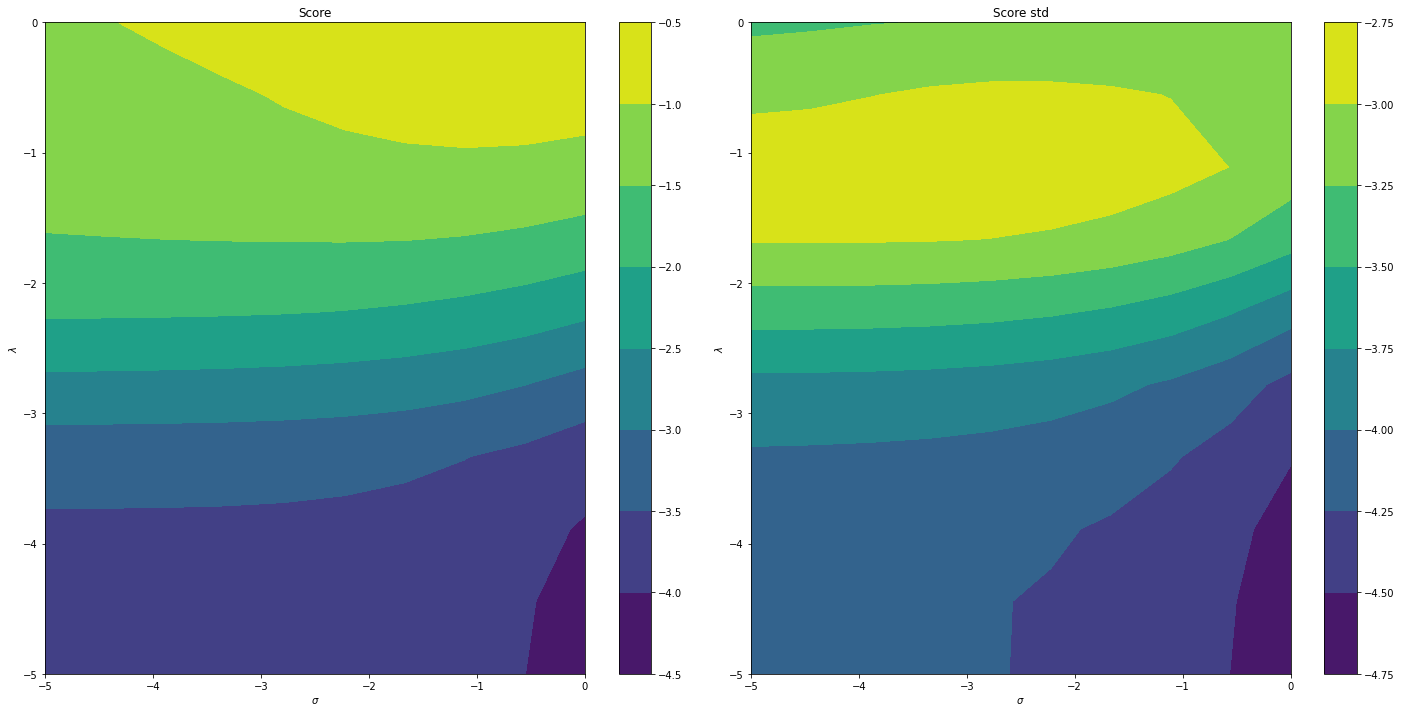

In [76]:

sv, lv = np.meshgrid(sgm, lmbd)

#fig = plt.figure(figsize = (10, 7))
#ax = plt.axes(projection ="3d")

#ax.scatter(sv, lv, np.log(scores))
#ax.set_xlabel('$\sigma$', fontsize=20)
#ax.set_ylabel('$\lambda$', fontsize=20)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf(sv, lv, np.log2(scores))
ax[0].set_xlabel('$\sigma$')
ax[0].set_ylabel('$\lambda$')
ax[0].set_title('Score')
fig.colorbar(cm0, ax=ax[0])


cm1 = ax[1].contourf(sv, lv, np.log2(scores_std))
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('$\lambda$')
ax[1].set_title('Score std')
fig.colorbar(cm1, ax=ax[1])


fig.tight_layout()